# Libraries

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from scipy.linalg import expm

In [ ]:
from IPython.display import clear_output

In [ ]:
# Need Diff.py file, change path accordingly
from Diff import *

# Visualization parameters and functions

The next few functions are not related to the solution of the diffusion process in itself, but they will help more in analyzing the results of our diffusion experiments (e.g. visualization, state evolution per node, etc.).

In [ ]:
def show_diffusion(data):

  '''
  ARGUMENTS:
    data : 2D Numpy array. Matrix of states of the nodes as time progresses.

  OUTPUT:
    none

  The function plots each iteration of the diffusion solver, so we get a time sequence of the "quantities" in each node of the graph.
  '''

  for i in range(data.shape[1]):
    nx.draw(G, pos=pos, with_labels=labels, node_color = np.array(data[:,i]), node_size=node_size, vmin=vmin, vmax=vmax, cmap = cmap)
    #plt.title('Diffusion at t = ' + str(round(i/10, 2)))
    plt.title('Iteration ' + str(i))
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)))
    plt.show()
    clear_output(wait=True)

In [ ]:
def plot_diffusion(data, nodes):

  '''
  ARGUMENTS:
    data : 2D Numpy array. Matrix of states of the nodes as time progresses.
    nodes : list of integers in the range 0 to n. Contains the labels of the nodes we want to see in the plot.

  OUTPUT:
    none

  This function plots the evolutions of the "quantities" in the chosen nodes as a function of time.
  '''

  for node in nodes:
    plt.plot(data[node, :], label=str(node))
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize='small')
  plt.xlabel('t')
  plt.ylabel('$u_i(t)$')
  plt.show()

In [ ]:
# Visualization parameters

vmin = 0
vmax = 100
cmap = plt.cm.get_cmap('jet') # plt.cm.Blues/Reds/etc... OR plt.cm.get_cmap('jet/rainbow/etc...')

'''https://matplotlib.org/stable/tutorials/colors/colormaps.html'''

node_size = 500
labels = True

# Diffusion

The following equation denotes the diffusion of a "quantity" on a graph
$$
\frac{d\psi}{dt} = -C\mathbf{L}\psi
$$
where $\psi$ is a vector representing the quantities present in each node of a graph and $\mathbf{L}$ is the Laplacian matrix of that graph. The solution $\psi(t)$ is given by a linear combination of the eigenvectors $v_i$ of $\mathbf{L}$:
$$
\psi(t) = \sum_i a_i(t) v_i
$$
where $a_i(t) = a_i(0) e^{-C\lambda_i t}$.

We will now test the diffusion on a stochatic block model.
(short explanation?)

We first define a few parameters for the construction of the stochastic block model, such as the number of blocks, the sizes of each block, the number (or density) of edges going from one block to another, etc.

Then, we set the initial conditions randomly by "activating" 20% of the nodes in the graph, while the quantity in the other nodes remains unchanged.

In [ ]:
sizes = [6, 5, 4]
probs = [[1, 0.05, 0.05], [0.05, 1, 0.05], [0.05, 0.05, 1]]

In [ ]:
G = nx.stochastic_block_model(sizes, probs, seed=0)
pos = nx.spring_layout(G)
A = nx.adjacency_matrix(G).todense()
L = nx.laplacian_matrix(G).toarray()


n = G.number_of_nodes()
x0 = np.zeros(n)
activ = np.random.choice(n, int(0.2*n))
x0[activ] = 100

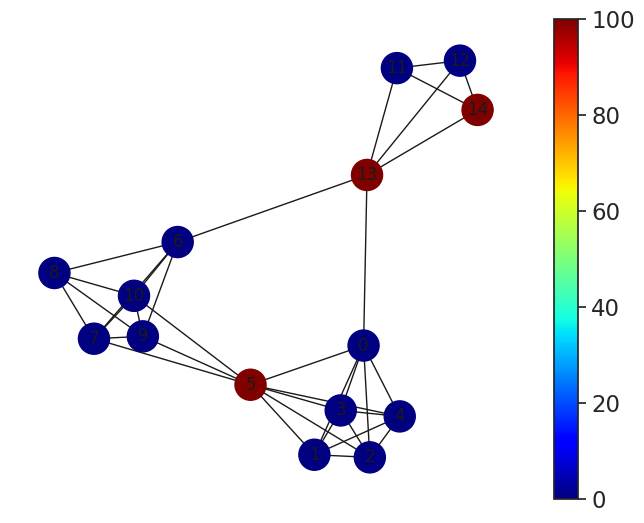

In [ ]:
# Visualize the graph and initial state

nx.draw(G, pos=pos, with_labels=labels, node_color=x0, cmap=cmap, node_size=node_size, vmin=vmin, vmax=vmax)
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)))
plt.show()

In [ ]:
diff = diffusion(L, x0)

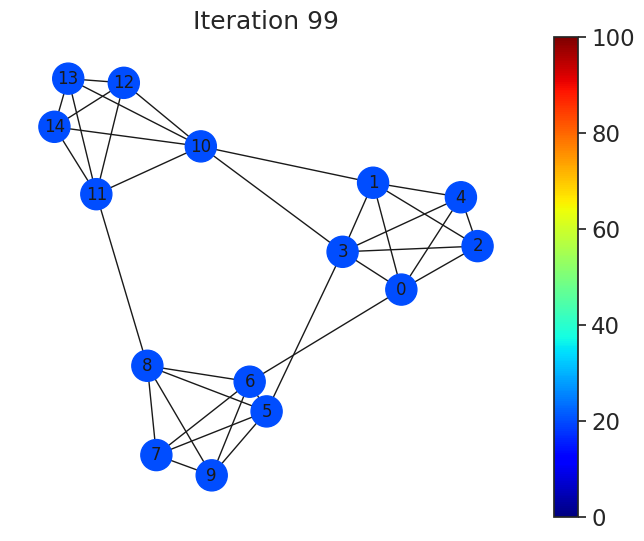

In [ ]:
show_diffusion(diff)

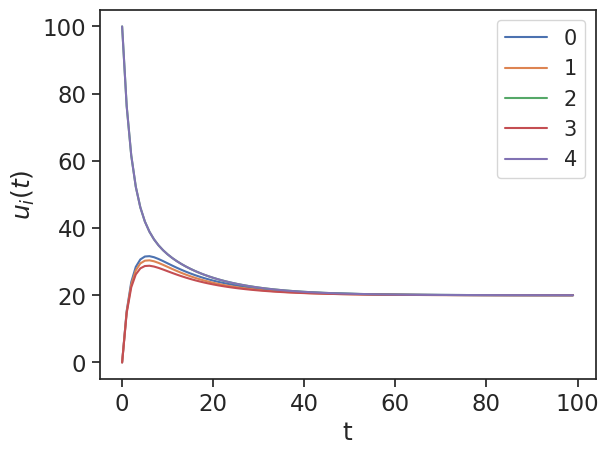

In [ ]:
# Choose the nodes by changing the numbers in the list
plot_diffusion(diff, [0,1,2,3,4])

How does the diffusion process in our SBM graph change when we assign different diffusivity parameters to each block? Our goal is now to change the weights of the edges in each region of the graph. This would be equivalent to solving the "non constant" version of our diffusion equation.

In other words, from the equation with constant diffusion $C$ given by
$$
\frac{d\psi}{dt} = -C\mathbf{L}\psi
$$
or, for each node $i$ in the graph
$$
\dot{\psi_i}(t) = C \sum_j A_{ij}(\psi_j - \psi_i)
$$
we can assign new diffusivity parameters $C_{ij}$ to obtain the following diffusion equation:
\begin{align}
\dot{\psi_i}(t) &= \sum_j C_{ij} A_{ij}(\psi_j - \psi_i) \\
&= \sum_j C_{ij} A_{ij}\psi_j - \psi_i \sum_j C_{ij} A_{ij} \\
&= \sum_j C_{ij} A_{ij} - \delta_{ij}(\sum_k C_{ik} A_{ik}) \psi_j \\
&= (C \odot A - D(C)) \psi(t)
\end{align}
where $D_{ij}(C) = \delta_{ij}\sum_k C_{ik} A_{ik}$.

In [ ]:
# Take kxk matrix and construct a C matrix with the same dimensions as A for Hadamard product
c_bar = np.array([[20,3,5],
              [3,15,2],
              [5,2,10]])

In [ ]:
C = construct_C(c_bar, sizes, n)
D = construct_D(A, C, n)
M = C*A - D

In [ ]:
diff_2 = ed_diffusion(M, x0, tau=0.01, T=5)

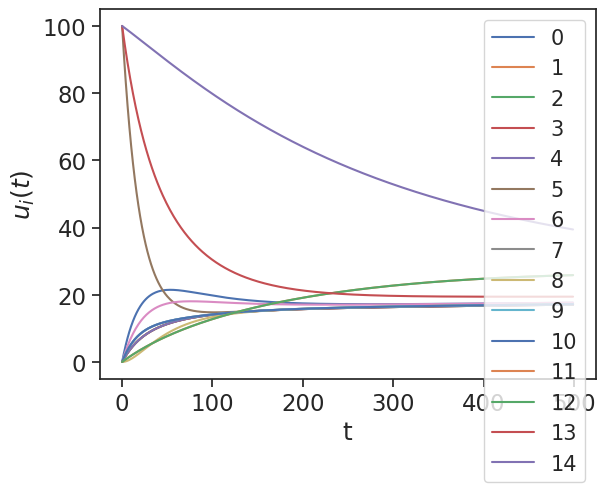

In [ ]:
plot_diffusion(diff_2, [i for i in range(n)])